# Beispiel für die Energiesystemmodellierung eines PV-Wärmepumpen Systems mit Netzanschluss

## Zunächst importieren wir die benötigten python Bibliotheken.

In [1]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt

## Import der Daten

Die Werte der Zeitreihen sind in einem Unterordner "data" als csv-Datein abgelegt. Sie werden mit Hilfe der python Bibliothek pandas eingelesen und als Variablen angelegt. Dabei werden Parameter wie der Seperator (hier ";") und die Indexspalte sowie die Funktion, aus der Indexspalte Zeit und Datenformate auszulesen gesetzt. 

In [2]:
electrical_load = pd.read_csv('./data/SumProfiles_Electricity.csv', sep = ';', index_col='Time', parse_dates=True)
heat_load = pd.read_csv('./data/SumProfiles_Gas.csv', sep = ';', index_col='Time', parse_dates=True)
pv_infeed = pd.read_csv('./data/pv_infeed.csv', sep = ';', index_col='Time', parse_dates=True)

Die eingelesenen Zeitreihen sind so noch nicht vollständig nutzbar. Um die Die Einspeisung der PV-Anlage zu normieren wird eine neue Spalte mit dem normierten Leistungsoutput sowie neue Spalten mir der Leistung der Last in den jeweiligen Variablen angelegt.

In [3]:
#Die gemessene PV-Einspeiseganglinie ist von einer Anlage mit einer Leistung von 3,5 kWp 
pv_infeed['p_max_pu'] = pv_infeed.power_kw/3.5 

#Das Profil hat eine Energienachfrage in kwh pro 10 Minuten, daher die Umrechnung in Leistung
electrical_load['power_kw'] = electrical_load.demand_kwh * (60.0/10.0)
heat_load['power_kw'] = heat_load.demand_kwh * (60.0/10.0)

Schauen wir uns die importierten und bearbeiteten Daten einmal an:

In [4]:
electrical_load.head()

,demand_kwh,power_kw
Time,,
2019-10-01 00:00:00,0.011889,0.071334
2019-10-01 00:10:00,0.020830,0.124979
2019-10-01 00:20:00,0.030474,0.182846
2019-10-01 00:30:00,0.023417,0.140502
2019-10-01 00:40:00,0.018474,0.110843


Um einen besseren Einblick zu erhalten, schauen wir uns nur einen Ausschnitt aller drei Tabellen an:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x124f53278>,
      dtype=object)

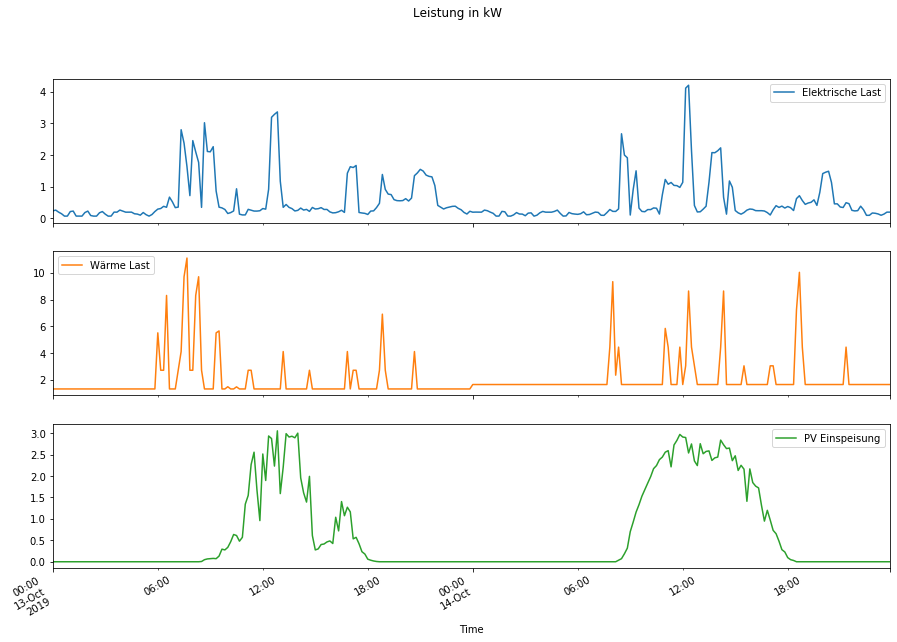

In [5]:
df_figure = pd.concat([electrical_load.power_kw, heat_load.power_kw, pv_infeed.power_kw], axis = 1)
df_figure.columns = ['Elektrische Last', 'Wärme Last', 'PV Einspeisung']
df_figure.loc['10-13-19 00:00:00':'10-14-19 23:50:00'].plot(subplots = True, figsize=(15,10), title= 'Leistung in kW')

## Definition von Anlagenparametern 

Die Paramter der PV-Anlage, sowie die Wärmepumpe und der Heizkessel mit thermischen Speicher werden hier definiert. Die Definition ist an reale techniche Anlagen angelehnt. Um Einflüsse der verscheidenen Komponenten auf die Ergebnisse zu erfassen, können sie geändert werden. 

### Komponenten des Haushalts 

Die Parameter sind in kW bzw. in cent/kWh angegeben und werden in ein python Dictionary gespeichert.

In [6]:
# PV-Anlage
pv = {"electrical_power": 10.0}

#Wärmepumpe
heat_pump = {"electrical_power": 3.0,
              "COP": 3.25}

#Heizkessel
heating_boiler = {"thermal_power": 20.0,
                   "efficiency":0.98,
                   "gas_costs": 4.5} #Kosten in cent/kWh

#Warmwasserspeicher
hot_water_storage =  {"thermal_power": 20.0,
                   "thermal_capacity":3.5, #Kapazität in kWh
                   "standing_loss": 0.01 #Selbstentlasdungsverluste in Energie des Speicherinhalts, der sich nach einer Stunde selbst entladen hat.
                     } 

### Netzanschluss 

Der Netzanschluss wird für den Haushalt mit 14,5 kW angenommen. 
Hier ist auch eine Kappungsgrenze bei 70% der Nennleistung der PV-Anlage implementiert.

In [7]:
# Leistungsbezug aus dem Netz
grid_import = {"electrical_power" : 14.5,
                "electricity_price": 30.0} #Preise in cent/kWh

#Leistungsabgabe in das Netz
grid_export = {"electrical_power" : 0.7 * pv["electrical_power"], #Repräsentiert die 70% Kappungsgrenze bei kleinen PV-Anlagen
                "electricity_revenue": 12.0} #EEG-Erlöse in cent/kWh

## Verwendung von pypsa um das Energiemodell aufzubauen

Im Folgenden verwenden wir die offene python bibliothek pypsa um unser Energiesystem zu bauen. Diese ist objektorientiert aufgebaut und hat verschiedene Module, welche zu einem Energiesystem zusammengesetz werden können. Gleichzeitig kann der Einsatz der Komponenten nach Grenzkosten bestimmt werden. Es lassen sich auch AC- und DC-Netzflussberechnungen sowie Kapazitätsplanungen mit der Bibliothek ausführen. 

### Definition des Netzwerks

Das Netzwerk ist das Pypsa Objekt, welches alle anderen Objekte enthält. Es definiert damit die Basisparmeter unseres Energiesystems. Wir erstellen zunächst ein leeres Netzwerk und definieren dann die Zeitschritte. Diese lesen wir aus den Eingangsdaten ab.

In [8]:
#Netzwerk definieren
network = pypsa.Network()
network.set_snapshots(pv_infeed.index)
network.snapshot_weightings = pd.Series(data = 1/6, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 10 Minuten also 1/6 Stunde.

#### Knoten definieren

An Knoten werden bei pypsa die Energieflüsse bilanziert und die Komponenten an diese angeschlossen. Wir definieren hier einen Strom- und einen Wärmeknoten.

In [9]:
#Stromknoten definieren
network.add("Bus", 
            name = "electricity", 
            v_nom = 0.4)

#Wärmeknoten definieren
network.add("Bus", 
            name = "heat")

#### Lasten definieren 

An jeden Knoten wird nun eine Last angeschlossen. Diese wird mit den Leistungszeitreihen der jeweiligen Lasten belegt.

In [10]:
# Elektrische Last
network.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)

# Wärmelast
network.add("Load", 
            name ="heat_load", 
            bus = "heat", 
            p_set = heat_load.power_kw)


#### Erzeugungseinheiten definieren

In pypsa sind Erzeugungseinheiten als "Generator" definiert. Diese haben eine installierte Leistung "p_nom" und ggf. eine normierte maximale Leistung "p_ma_pu".
Wir definieren die PV-Anlage und den Heizkessel.

In [11]:
#PV-Anlage
network.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network.add("Generator", 
            name = "boiler", 
            bus = "heat", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

#### Speicher definieren

Wir definieren den Speicher. Dabei wird ein Hilfknoten definiert, an welchem die Einspeicherleistung, die Ausspeicherleistung als steuerbare Verbindung zwischen zwei Knoten und der Speicher selbst angeschlossen werden.  

In [12]:
# Hilfsknoten
network.add("Bus", 
            name = "storage_heat")

#Einspeicherleistung vom Knoten "heat" zum Knoten "storage_heat"
network.add("Link", 
            name = "hot_water_storage_charge", 
            bus0 = "heat", 
            bus1 = "storage_heat", 
            p_nom = hot_water_storage["thermal_power"])

#Ausspeicherleistung vom Knoten "storage_heat" zum Knoten "heat"
network.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "storage_heat", 
            bus1 = "heat", 
            p_nom = hot_water_storage["thermal_power"])

#Speicher
network.add("Store", 
            name = "hot_water_storage", 
            bus = "storage_heat", 
            e_nom = hot_water_storage["thermal_capacity"],
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            standing_loss = hot_water_storage["standing_loss"]
            )

#### Netzanschluss definieren

Der Netzanschluss wird hier auch als "Generator" definiert. Das heißt es kann Leistung aus dem Netz für einen bestimmten Preis bezogen werden. Die Netzeinspeisung wird auch als "Generator" definiert, allerdings wird die Leistungsabgabe dieses Generators mit einem Vorzeichenwechsel umgedreht. Der "Generator" kann also Leistung aufnehmen. Zusätzlich sind die Kosten negativ um Erlöse durch die EEG-Vergütung abzubilden. 

In [13]:
#Netzbezug
network.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

#Netzeinspeisung
network.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

#### Implementierung der Wärmepumpe

Die Wärmepumpe wird als "Link" zwischen den Knoten "electricity" und "heat" implementiert. Sie hat eine Effizienz, welche größer als eins ist, um die genutzte Umgebungswärme abzubilden.

In [14]:
#Wärmepumpe
network.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="heat", 
            p_nom=heat_pump["electrical_power"],
            efficiency = heat_pump["COP"]
           )

## Simulation der Basiskonfiguration ohne Wärmepumpe

Um die Basisvariante ohne Wärmepumpe zu berechnen setzten wir die Leistung der Wärmepumpe temporär auf 0. 
Die in pypsa implementierte Funktion lopf optimiert den Einsatz aller Komponenten so, dass die dabei entstehenden Kosten minimal sind.

In [15]:
network.links.loc['heat_pump', 'p_nom'] = 0.0

Wir überprüfen kurz, ob die installierte Leistung wirklich bei 0 liegt.

In [16]:
print(network.links.p_nom)

hot_water_storage_charge       20.0
hot_water_storage_discharge    20.0
heat_pump                       0.0
Name: p_nom, dtype: float64


In [17]:
# Simulation der Basiskonfiguration für den kompletten Zeitraum:
network.lopf(solver_name = "cbc", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.43s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.03e+03


('ok', 'optimal')

## Auswertungsfunktion

Funktionen werden in python üblicherweise am Anfang eines Scriptes definiert. Aus didaktischen Gründen kommt die Definition der Funktion erst jetzt. Für Aufgaben, welche wir mehrfach ausführen lohnt sich die Definition einer Funktion. Diese kann dann im weiteren Verlauf immer wieder aufgerufen werden. 
Wir werten hier das gelöste Netzwerk nach den gewünschten Parametern aus. 

In [18]:
#Auswertung der Kosten und Anteile
def cost_share_evaluation(network):
    '''
    This function evaluate the solved pypsa network to get the costs, revenues and the share of the selfconsumption.
    
    Parameters
    ----------
    network:            pypsa Network
                        The solved pypsa network with all corresponding devices
    Returns
    -------
    results :           dict
                        The dictionary with all the results.
    '''
    
    grid_import = (network.generators_t.p['grid_import'] * network.snapshot_weightings).sum()
    grid_export = (network.generators_t.p['grid_export'] * network.snapshot_weightings).sum()
    self_consumed_pv = (network.generators_t.p['pv'] * network.snapshot_weightings).sum()- grid_export
    self_consumption_ratio = self_consumed_pv/(grid_import + self_consumed_pv)
    
    electricity_cost = grid_import * network.generators.marginal_cost['grid_import']
    electricty_revenues = grid_export * network.generators.marginal_cost['grid_export']
    gas_costs = (network.generators_t.p['boiler']*network.snapshot_weightings).sum() * network.generators.marginal_cost['boiler']
    
    curtailment = ((network.generators_t.p_max_pu['pv']*network.generators.p_nom['pv'] - network.generators_t.p['pv'])*network.snapshot_weightings).sum()

    results = {"Eigenverbrauchsanteil": self_consumption_ratio,
              "Stromkosten": electricity_cost,
              "Gaskosten": gas_costs,
              "Stromerlöse": -electricty_revenues,
              "Gesamtkosten": electricity_cost + gas_costs + electricty_revenues,
              "Nicht nutzbare Energie": curtailment}
    results_energy = {'Abregelung': curtailment,
                      'Netzeinspeisung': grid_export,
                      'Eigenverbrauch': self_consumed_pv,
                      'Netzbezug': -grid_import}
                      
    return results, results_energy

Ausführung der Auswertungsfunktion

In [19]:
results_without_heatpump, results_energy_without_heatpump  = cost_share_evaluation(network)

#Die Werte sollen auch als Text ausgegeben werden
print("Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt "
      + str(round(results_without_heatpump["Eigenverbrauchsanteil"]*100,2))
      +"%. Dabei entstehen Stromkosten von "
      +str(round(results_without_heatpump["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_without_heatpump["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_without_heatpump["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_without_heatpump["Nicht nutzbare Energie"]/100,1))+ "kWh PV-Strom abgeregelt werden müssen."
      +" Die Gesamtkosten betragen "+ str(round(results_without_heatpump["Gesamtkosten"]/100,2)) +"€."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt 36.79%. Dabei entstehen Stromkosten von 86.81€, Gaskosten von 80.88€ und EEG-Erlöse von 87.37, wobei 0.1kWh PV-Strom abgeregelt werden müssen. Die Gesamtkosten betragen 80.31€.


### Visualisierung der Ergebnisse

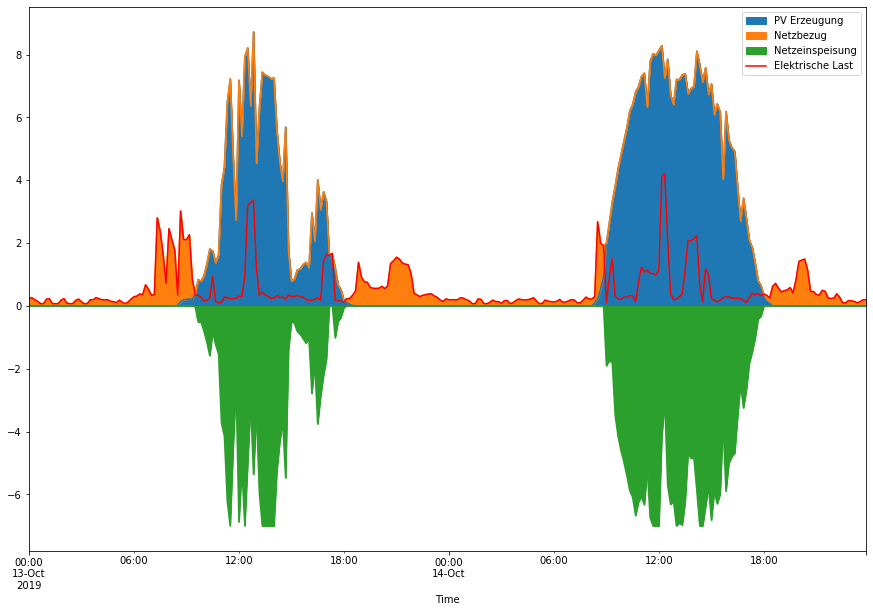

In [20]:
df_figure_without_heatpump = pd.concat([network.generators_t.p['pv'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export']], axis = 1)
df_figure_without_heatpump.columns = ['PV Erzeugung', 'Netzbezug', 'Netzeinspeisung']
ax = df_figure_without_heatpump.loc['10-13-19 00:00:00':'10-14-19 23:50:00'].plot(subplots = False, figsize=(15,10), kind= 'area')
load_figure = network.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
load_figure.loc['10-13-19 00:00:00':'10-14-19 23:50:00'].plot(legend = True, color = 'red', ax = ax)

## Erweiterte Konfiguration mit Wärmepumpe 

Um die Eigenverbrauchsoptimierung mit Hilfe der Wärmepumpe zu berechnen, wird die Wärmepumpe wieder mit ihrer Nennleistung implementiert und die Simulation erneut durchgeführt. 

In [21]:
network.links.loc['heat_pump', 'p_nom'] = heat_pump["electrical_power"]

## Simulation der Konfiguration mit Wärmepumpe

In [22]:
# Simulation für den kompletten Zeitraum:
network.lopf(solver_name = "cbc", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.38s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 7.36e+03


('ok', 'optimal')

In [23]:
# Ausführung der Auswertungsfunktion
results_with_heatpump, results_energy_with_heatpump = cost_share_evaluation(network)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der Konfiguration mit Wärmepumpe beträgt "
      + str(round(results_with_heatpump["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_with_heatpump["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_with_heatpump["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_with_heatpump["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_heatpump["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_with_heatpump["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_with_heatpump["Eigenverbrauchsanteil"]- results_without_heatpump["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_without_heatpump["Gesamtkosten"]-results_with_heatpump["Gesamtkosten"])/100,2))
      +"€."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der Konfiguration mit Wärmepumpe beträgt 53.98%.
 Dabei entstehen Stromkosten von 86.81€, Gaskosten von 55.44€ und EEG-Erlöse von 68.62, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 73.62€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 17.19 Prozentpunkte und eine Verringerung der Kosten um 6.69€.


## Visualisierung der Ergebnisse

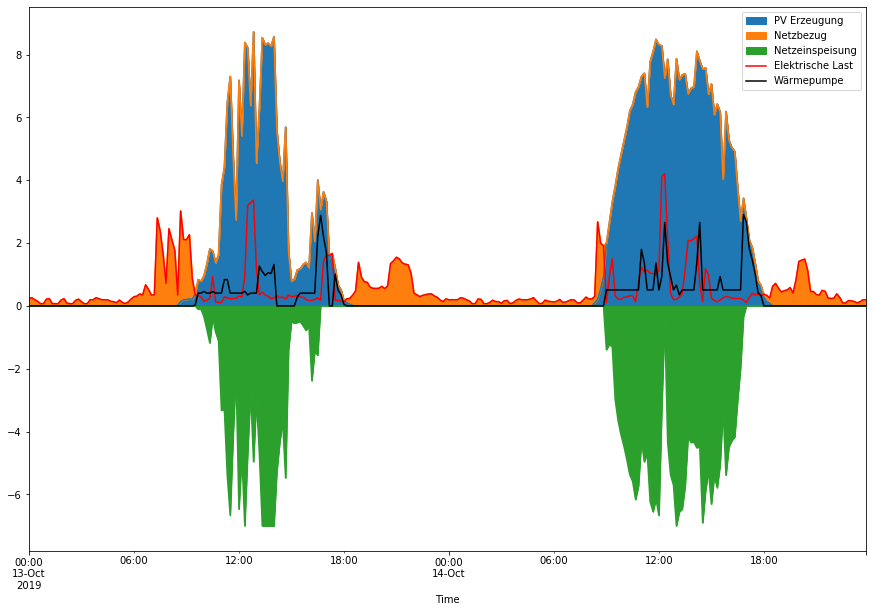

In [24]:
df_figure_with_heatpump = pd.concat([network.generators_t.p['pv'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export']], axis = 1)
df_figure_with_heatpump.columns = ['PV Erzeugung', 'Netzbezug', 'Netzeinspeisung']
ax = df_figure_with_heatpump.loc['10-13-19 00:00:00':'10-14-19 23:50:00'].plot(subplots = False, figsize=(15,10), kind= 'area')
total_load = pd.concat([network.loads_t.p_set['electricity_load'], network.links_t.p0['heat_pump']], axis = 1)
total_load.columns = ['Elektrische Last', 'Wärmepumpe']
total_load.loc['10-13-19 00:00:00':'10-14-19 23:50:00'].plot(color = ['red', 'black'], legend = True, stacked = False, ax=ax)

In [25]:
energy_figure = pd.DataFrame([results_energy_without_heatpump, results_energy_with_heatpump], index = ['Ohne Wärmepumpe', 'Mit Wärmepumpe'])

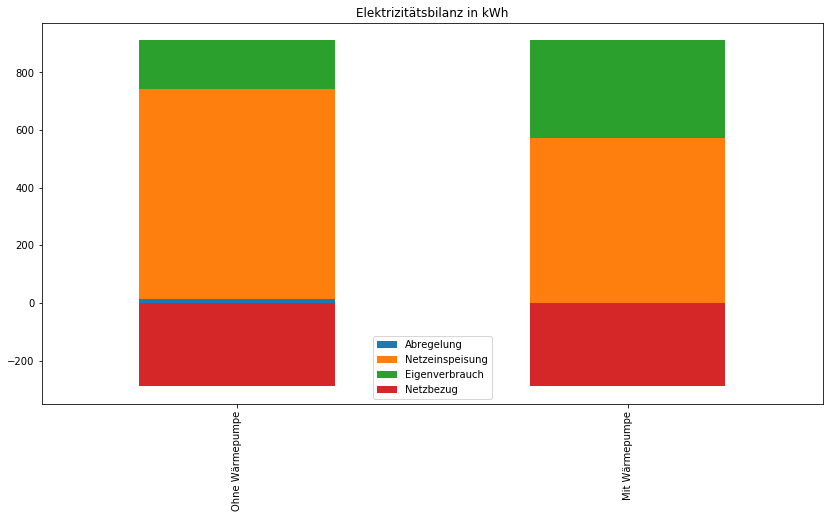

In [27]:
energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh')